In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
## Let's start by loading our data

# Starting with the labels
with open("./data/processed_training_labels.csv") as labels_file:
    labels_string = labels_file.read()
    labels = np.array(labels_string.split(','), dtype=int)
    
# Recall we had 60000 images. Let's make sure we didn't lose anythin
assert len(labels) == 60000

# Now for the images
images = []
with open("./data/processed_training_images") as images_file:
    raw_image_strings = images_file.readlines()
    for img_string in raw_image_strings:
        img_flat = np.array(img_string.split(","), dtype=np.double)
        img = np.reshape(img_flat, (28,28))
        images.append(img)
        
# Again, let's do some random spot checking to make sure everything is as we expect
assert len(images) == 60000
i1,i2,i3 = np.random.randint(0, 60000, 3)
assert images[i1].shape == (28,28)
assert images[i2].shape == (28,28)
assert images[i3].shape == (28,28)

In [ ]:
# And again, we'll just print out some images and their labels for good measure 

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,4,1)
plt.text(9,40,f"label: {labels[i1]}")
plt.imshow(images[i1], cmap='gray')
fig.add_subplot(1,4,2)
plt.text(10,40,f"label: {labels[i2]}")
plt.imshow(images[i2], cmap='gray')
fig.add_subplot(1,4,3)
plt.text(11,40,f"label: {labels[i3]}")
plt.imshow(images[i3], cmap='gray')

In [4]:
## Okay! Now the fun begins.
# To start, let's just get everything over to Torch
t_labels = torch.tensor(labels)
t_images = torch.tensor(images)

train_images = t_images.reshape(60000, 1, 784).float()
train_labels = torch.zeros(60000, 1, 10)
for i, label in enumerate(t_labels):
    train_labels[i][0][label.item()] = 1

#train_labels = train_labels.flip(0)
#train_images = train_images.flip(0)

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


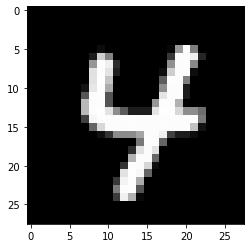

In [5]:
# And we can take a look at their shapes
import matplotlib.pyplot as plt
z = np.random.randint(0, 60000)
plt.imshow(train_images[z][0].reshape(28,28), cmap='gray')
print(train_labels[z][0])

In [210]:
# TODO: !DF! Try just one fully connected layer
# TODO: !DF! Write explanation on MSELoss()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1,1,3)  # stride = 1
        #self.drop1 = nn.(389,p=.2) 
        self.fc1 = nn.Linear(782,100) # 80
        #self.drop2 = nn.Dropout()
        self.fc2 = nn.Linear(100, 10)
        #self.fc3 = nn.Linear(100, 10) # 80
        
    def forward(self, x):
        #x = F.max_pool1d(F.sigmoid(self.conv1(x)), (2))  ## TODO: Test this again against whatever you leave here
        x = F.sigmoid(self.conv1(x))
        #x = self.drop1(x)
        x = F.sigmoid(self.fc1(x))
        #x = F.sigmoid(self.fc2(x))
        #x = self.drop2(x)
        #x = F.relu(self.fc2(x))
        return self.fc2(x)
        #return self.fc3(x)

## 100 -> ~76 ~78 ~78 ~78%
## 80 -> ~78 ~76 ~ 77 ~78%

## 100 with max_pool -> 71%, 73% 71%
#https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073
# 5 Epochs with +-[1/sqrt(n)] weights + pytorch bias, Sigmoid, Kernel Size 3: 85%, 86%, 86%
# 5 Epochs with pytorch weights/bias, Sigmoid, Kernel Size 3: 87%, 86%, 86%, 85%
# 5 Epochs with +-[1/sqrt(n)] weights + 0 bias, Sigmoid, Kernel Size 3: 86%, 86%, 86%, 85%
# 5 Epochs with +-[1/sqrt(n)] weights and bias, Sigmoid, Kernel Size 3: 86%, 85%, 86%
#  5 Epochs with Normalized Xavier weights and 0 bias, Sigmoid, Kernel Size 3: 87%, 87%, 86%,(5) -- 90.35% 90.44%  (10) **
#  5 Epochs with Normalized Xavier weights and 0 bias, Sigmoid, Kernel Size 5: 86%, 86%, 86% (5) -- 89.31% 90.03%  (10)
#  5 Epochs with Normalized Xavier weights and 0 bias, Sigmoid, Kernel Size 8: 87%, 86%, 87% (5) -- 89.79% 88.58%  (10)

## TODO: !DF! Best of the normalized Xavier head-to-head with pytorch defaults, 10 epochs, track loss

In [211]:
net = Net()
net = net
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
# https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
# TODO:!DF! test with and without these weights
#net.fc1.weight.data.uniform_(-1.0/np.sqrt(782),1.0/np.sqrt(782))
#_ = net.fc2.weight.data.uniform_(-1.0/np.sqrt(100),1.0/np.sqrt(100))
#net.fc1.bias.data.uniform_(-1.0/np.sqrt(782),1.0/np.sqrt(782))
#_ =  net.fc2.bias.data.uniform_(-1.0/np.sqrt(100),1.0/np.sqrt(100))-np.sqrt(6.0)
net.fc1.bias.data.fill_(0)
_ = net.fc2.bias.data.fill_(0)
net.fc1.weight.data.uniform_(-np.sqrt(6.0)/np.sqrt(782+100),np.sqrt(6.0)/np.sqrt(782+100))
_ = net.fc2.weight.data.uniform_(-np.sqrt(6.0)/np.sqrt(100+10),np.sqrt(6.0)/np.sqrt(100+10))

In [212]:
from IPython.display import display, clear_output
criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01)
for epoch in range(10):
    running_loss = 0.0
    for i in range(0,len(train_images), 4):
        net.zero_grad()
        out = net(train_images[i:i+4])
        loss = criterion(out, train_labels[i:i+4])
        loss.backward()
        running_loss += loss.item()
        if i % 2000 == 0:
            ## I recommend doing things like this. It helped me catch mistakes
            #print(batch[0][0])
            #plt.imshow(batch[0][0].reshape((28,28)), cmap='gray')
            #plt.show()
            #print(targets[0])
            clear_output(wait=True)
            display(f"Epoch: {epoch}, Batch: {i}, running_loss: {running_loss}")
            running_loss = 0.0
        for f in net.parameters():
            f.data.sub_(f.grad.data * 0.01)
        
    

'Epoch: 9, Batch: 58000, running_loss: 11.266556797199883'

In [ ]:
plt.imshow(t_images[750], cmap='gray')

In [ ]:
torch.argmax(net(t_images[750].flatten().float().unsqueeze(0).unsqueeze(0)))

In [10]:
with open("./data/processed_testing_labels.csv") as labels_file:
    labels_string = labels_file.read()
    testing_labels = np.array(labels_string.split(','), dtype=int)
    
# Recall we had 60000 images. Let's make sure we didn't lose anythin
assert len(testing_labels) == 10000

# Now for the images
testing_images = []
with open("./data/processed_testing_images") as images_file:
    raw_image_strings = images_file.readlines()
    for img_string in raw_image_strings:
        img_flat = np.array(img_string.split(","), dtype=np.double)
        img = np.reshape(img_flat, (28,28))
        testing_images.append(img)

In [11]:
t_test_labels = torch.tensor(testing_labels)
t_test_images = torch.tensor(testing_images)

In [213]:
test_imgs = t_test_images
test_labels = t_test_labels
correct = []
for i,img in enumerate(test_imgs):
    res = torch.argmax(net(img.flatten().float().unsqueeze(0).unsqueeze(0)))
    targ = test_labels[i]
    if res == targ:
        correct.append(1)
    else:
        correct.append(0)

print(f"{sum(correct)} / {len(correct)}")

9044 / 10000


In [ ]:
img = t_test_images[9496]
plt.imshow(img, cmap='gray')

In [ ]:
torch.argmax(net(img.flatten().float().unsqueeze(0).unsqueeze(0)))

In [ ]:
img.shape

In [ ]:
img.flatten().shape

In [ ]:
##torch.save(net, "./models/1dC2fc85")
##torch.save(net.state_dict(), "./models/1dC2fc85.state_dict")

In [ ]:
train_labels.flip(0)

In [ ]:
my_img = train_images[0][0]
my_conv1d = nn.Conv1d(1,2,2)
my_conv1d(my_img.unsqueeze(0).unsqueeze(0))[0]


In [ ]:
f = nn.Conv1d(1,1,3)

In [ ]:
f(train_images[0].unsqueeze(0)).shape

In [ ]:
104/26

In [68]:
ll = nn.Linear(782,100)
ll2 = nn.Linear(782, 100)
ll2.weight.data.uniform_(-1.0/np.sqrt(782),1.0/np.sqrt(782))

tensor([[-0.0344, -0.0227, -0.0099,  ...,  0.0357,  0.0121, -0.0129],
        [-0.0289, -0.0260, -0.0018,  ...,  0.0205, -0.0217,  0.0199],
        [ 0.0091,  0.0305,  0.0191,  ..., -0.0006,  0.0047, -0.0305],
        ...,
        [-0.0057,  0.0190, -0.0134,  ..., -0.0067,  0.0096, -0.0161],
        [ 0.0202, -0.0128, -0.0338,  ..., -0.0176, -0.0176,  0.0211],
        [-0.0263, -0.0035,  0.0092,  ..., -0.0211, -0.0109, -0.0111]])

In [69]:
ll.weight.data.median()

tensor(3.6307e-05)

In [70]:
ll2.weight.data.median()

tensor(-8.7258e-05)

In [82]:
ll.weight.size(1)

782

In [180]:
losses = np.zeros((5,15000,1))


In [181]:
losses.shape

(5, 15000, 1)

In [183]:
losses[0].shape

(15000, 1)